In [1]:
from google.colab import files

In [2]:
files.upload()

Saving flower-dataset-archive.zip to flower-dataset-archive.zip


In [3]:
ls

flower-dataset-archive.zip  sample_data/


In [4]:
!unzip flower-dataset-archive.zip

Archive:  flower-dataset-archive.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  


In [5]:
ls

flower-dataset-archive.zip  flowers/  sample_data/


In [6]:
import os
import shutil
import numpy as np
import glob
import keras.backend as K
from keras import layers, optimizers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.initializers import glorot_uniform
from keras.layers import Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
import scipy.misc
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input


In [7]:
from matplotlib.pyplot import imshow
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [8]:
from tensorflow.python import train
# Arranging dataset paths
data_dir = '/content/flowers'
training_dir = '/content/Train'
testing_dir = '/content/Test'
train_test_ratio = 0.8

def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, testing_data_dir = testing_dir, train_test_ratio = train_test_ratio):
  if not os.path.exists(training_dir):
    os.mkdir(training_dir)

  if not os.path.exists(testing_dir):
    os.mkdir(testing_dir)

  num_training_files = 0
  num_testing_files = 0

  for subdir, dirs, files in os.walk(all_data_dir):
    catagory_name = os.path.basename(subdir)
    if(catagory_name == os.path.basename(all_data_dir)):
      continue

    training_data_catagory_dir = training_data_dir + '/' + catagory_name
    testing_data_catagory_dir = testing_data_dir + '/' + catagory_name

    #creating sub directroy for each sub catagory
    if not os.path.exists(training_data_catagory_dir):
      os.mkdir(training_data_catagory_dir)

    if not os.path.exists(testing_data_catagory_dir):
      os.mkdir(testing_data_catagory_dir)

    file_list = glob.glob(os.path.join(all_data_dir, subdir, '*.jpg'))

    print(str(catagory_name) + ' has ' + str(len(files)) + ' images.')


    random_set = np.random.permutation((file_list))

    #copy data to train and test directories
    train_list = random_set [:round(len(random_set)*(train_test_ratio))]
    test_list = random_set [-round(len(random_set )*(1-train_test_ratio)):]

    for lists in train_list:
      shutil.copy(lists, training_data_dir + '/' + catagory_name + '/')
      num_training_files += 1

    for lists in test_list:
      shutil.copy(lists, testing_data_dir + '/' + catagory_name + '/')
      num_testing_files += 1

  print("Processed " + str(num_training_files) + " training files.")
  print("Processed " + str(num_testing_files) + " testing files.")

In [9]:
split_dataset_into_test_and_train_sets()

tulip has 984 images.
daisy has 764 images.
rose has 784 images.
sunflower has 733 images.
dandelion has 1052 images.
Processed 3453 training files.
Processed 864 testing files.


In [10]:
ls

flower-dataset-archive.zip  flowers/  sample_data/  Test/  Train/


In [29]:
cd ..

/content


In [30]:
ls

flower-dataset-archive.zip  flowers/  sample_data/  Test/  Train/


In [73]:
from keras.models import Model
from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D
# Number of classes in dataset
num_classes = 5

def get_model():
  # Here rasnet50 is used as base model
  base_model = ResNet50(weights = 'imagenet', include_top = False)

  # As we are using rasnet50 as base model for feature extraction only
  # freezing the layers in the base model
  for layer in base_model.layers:
    layer.trainable = False

  # Storing the base model output
  base_model_output = base_model.output

  # Adding out layer
  x = GlobalAveragePooling2D()(base_model_output)
  # Adding dense layer
  x = Dense(512, activation='relu')(x)
  x = Dense(num_classes, activation='softmax', name='fcnew')(x)

  model = Model(inputs=base_model.input, outputs = x)

  return model

In [74]:
model = get_model()

model.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [80]:
# Defining the image data generator for train and test image

from keras.preprocessing.image import ImageDataGenerator

image_size = (244, 244)
batch_size = 32

train_data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_data_gen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_data_gen.flow_from_directory(
    testing_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3453 images belonging to 5 classes.
Found 864 images belonging to 5 classes.


In [81]:
# Training the fully connected layer for initial epochs
training_epochs = 15

# model training
model.fit_generator(
    train_generator,
    steps_per_epoch = (train_generator.n // batch_size),
    validation_data = valid_generator,
    validation_steps = (valid_generator.n // batch_size),
    epochs = training_epochs,
    verbose = 1
)


Epoch 1/15
107/107 [==============================] - 65s 597ms/step - loss: 0.2776 - accuracy: 0.9076 - val_loss: 0.2790 - val_accuracy: 0.8970
Epoch 2/15
107/107 [==============================] - 61s 571ms/step - loss: 0.2431 - accuracy: 0.9146 - val_loss: 0.2898 - val_accuracy: 0.8970
Epoch 3/15
107/107 [==============================] - 61s 572ms/step - loss: 0.2184 - accuracy: 0.9258 - val_loss: 0.2609 - val_accuracy: 0.8970
Epoch 4/15
107/107 [==============================] - 61s 572ms/step - loss: 0.2046 - accuracy: 0.9307 - val_loss: 0.2498 - val_accuracy: 0.9074
Epoch 5/15
107/107 [==============================] - 61s 565ms/step - loss: 0.1865 - accuracy: 0.9407 - val_loss: 0.2473 - val_accuracy: 0.9039
Epoch 6/15
107/107 [==============================] - 60s 561ms/step - loss: 0.1734 - accuracy: 0.9415 - val_loss: 0.2484 - val_accuracy: 0.9062
Epoch 7/15
107/107 [==============================] - 61s 573ms/step - loss: 0.1588 - accuracy: 0.9500 - val_loss: 0.2410 - val_ac

In [15]:
# More finetuning the model
# Training the model after 150 layers

training_epochs = 10

split = 140
for layer in model.layers[:split]:
  layer.trainable = False
for layer in model.layers[split:]:
  layer.trainable = True

model.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Choosing lower learning rate for finetuning
sgd_updated = optimizers.SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov = True)

model.compile(loss = 'categorical_crossentropy', optimizer=sgd_updated, metrics=['accuracy'])

# model training
model.fit_generator(
    train_generator,
    steps_per_epoch = (train_generator.n // batch_size),
    validation_data = valid_generator,
    validation_steps = (valid_generator.n // batch_size),
    epochs = training_epochs,
    verbose = 1
)



Epoch 1/10
53/53 [==============================] - 74s 1s/step - loss: 0.3609 - accuracy: 0.8873 - val_loss: 0.2930 - val_accuracy: 0.8930
Epoch 2/10
53/53 [==============================] - 63s 1s/step - loss: 0.2331 - accuracy: 0.9318 - val_loss: 0.2491 - val_accuracy: 0.9087
Epoch 3/10
53/53 [==============================] - 66s 1s/step - loss: 0.1793 - accuracy: 0.9472 - val_loss: 0.2257 - val_accuracy: 0.9123
Epoch 4/10
53/53 [==============================] - 69s 1s/step - loss: 0.1423 - accuracy: 0.9596 - val_loss: 0.2178 - val_accuracy: 0.9183
Epoch 5/10
53/53 [==============================] - 75s 1s/step - loss: 0.1096 - accuracy: 0.9678 - val_loss: 0.2058 - val_accuracy: 0.9255
Epoch 6/10
53/53 [==============================] - 83s 2s/step - loss: 0.0935 - accuracy: 0.9740 - val_loss: 0.2112 - val_accuracy: 0.9291
Epoch 7/10
53/53 [==============================] - 95s 2s/step - loss: 0.0766 - accuracy: 0.9805 - val_loss: 0.2094 - val_accuracy: 0.9375
Epoch 8/10
53/53 [==

In [69]:
import numpy as np
from sklearn.utils import compute_class_weight
from tensorflow.keras import optimizers

# Get the class labels
class_labels = np.unique(train_generator.classes)

# Calculate class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = class_labels,
                                        y = train_generator.classes
                                    )

# Convert class weights to a dictionary
class_weights_dict = dict(zip(class_labels, class_weights))

# More finetuning the model
training_epochs = 10

split = 140
for layer in model.layers[:split]:
    layer.trainable = False
for layer in model.layers[split:]:
    layer.trainable = True

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Choosing lower learning rate for finetuning
sgd_updated = optimizers.legacy.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd_updated, metrics=['accuracy'])

# Model training with class weights
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=training_epochs,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/10
53/53 [==============================] - 78s 1s/step - loss: 0.0382 - accuracy: 0.9935 - val_loss: 0.2109 - val_accuracy: 0.9339
Epoch 2/10
53/53 [==============================] - 71s 1s/step - loss: 0.0377 - accuracy: 0.9935 - val_loss: 0.2078 - val_accuracy: 0.9363
Epoch 3/10
53/53 [==============================] - 72s 1s/step - loss: 0.0283 - accuracy: 0.9959 - val_loss: 0.2059 - val_accuracy: 0.9387
Epoch 4/10
53/53 [==============================] - 64s 1s/step - loss: 0.0263 - accuracy: 0.9956 - val_loss: 0.2059 - val_accuracy: 0.9351
Epoch 5/10
53/53 [==============================] - 63s 1s/step - loss: 0.0274 - accuracy: 0.9938 - val_loss: 0.2036 - val_accuracy: 0.9387
Epoch 6/10
53/53 [==============================] - 68s 1s/step - loss: 0.0214 - accuracy: 0.9968 - val_loss: 0.2064 - val_accuracy: 0.9387
Epoch 7/10
53/53 [==============================] - 68s 1s/step - loss: 0.0185 - accuracy: 0.9976 - val_loss: 0.2033 - val_accuracy: 0.9423
Epoch 8/10
53/53 [==

In [17]:
pwd

'/content'

In [71]:
class_labels = list(train_generator.class_indices.keys())
class_indices = train_generator.class_indices

print('Class labels: ', class_labels)
print('class indices: ', class_indices)

Class labels:  ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
class indices:  {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


1/1 [==============================] - 0s 175ms/step
Predictions:
[[0.22607379 0.3930454  0.03982215 0.00194008 0.3391186 ]]
Index:  1


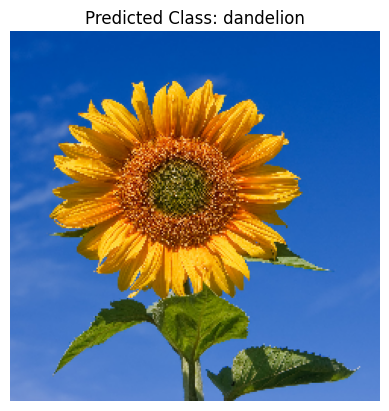

In [84]:
import cv2
import matplotlib.pyplot as plt

image_size = (244, 244)

# Load and preprocess the test image
image_path = '/content/3.jpg'
image = cv2.imread(image_path)

# Resize to the input size used during training
image = cv2.resize(image, image_size)

image = image.astype('float32') / 255.0 # Normalize pixel values

# Expand dimensions to add a batch dimension
image = np.expand_dims(image, axis=0)

# Make predictions
predictions = model.predict(image)

print('Predictions:')
print(predictions)

# Get the predicted class index
predicted_class_index = np.argmax(predictions[0])  # Assumes a single image batch
print('Index: ', predicted_class_index)

# Define class labels
class_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
# Display the image and predicted class label
plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB))
plt.title('Predicted Class: ' + predicted_class_label)
plt.axis('off')
plt.show()